# Simulation of ultrasound wave propagation in anisotropic media

This notebook performs an ultrasound simulations in a 2D anisotropic medium with a strong reflector using the spectral-element solver Salvus (https://mondaic.com/). The notebook reproduces the results in Fig. 5 of the reference manuscript:

Korta Martiartu et al, "Toward speed-of-sound anisotropy quantification in muscle with pulse-echo ultrasound", IEEE-TUFFC, 2022. DOI tba

Note: Check https://mondaic.com/docs/0.12.2/installation for installation of required packages

Salvus version: 0.11.37-6-gb6ac8fde

In [1]:
# Define max frequency of simulations

MAX_FREQUENCY_IN_MHz = 1.0

#### python environment

In [2]:
%matplotlib inline

# This line helps with tab-completion of the simple_config objects.
%config Completer.use_jedi = False

In [3]:
# Standard Python packages
import numpy as np
import matplotlib.pyplot as plt
from pyasdf import ASDFDataSet
import h5py
from scipy import interpolate
from math import cos, sin, pi

# Workflow management.
import salvus.flow.api

# Specific objects to aid in setting up simulations.
from salvus.mesh.simple_mesh import basic_mesh
import salvus.flow.simple_config as sc
from salvus.toolbox import toolbox

#### Generate a mesh

In [4]:
%%writefile layered_model_acousanisotropic.bm
NAME         acou_anisot
UNITS        m
ACOUSTIC     TRUE
COLUMNS      depth rho vp
 0.0     1.0e3     1.515e3
 0.095    1.0e3     1.515e3 
 0.095    1.18e3     2.67e3 
 0.100   1.18e3    2.67e3


Overwriting layered_model_acousanisotropic.bm


In [5]:
# Generate a mesh using the "simplified" meshing interface.
mesh_config = basic_mesh.CartesianFromBm2D(bm_file='layered_model_acousanisotropic.bm', 
                                           x_max=0.12,
                                           y_max=0.10,
                                           max_frequency=MAX_FREQUENCY_IN_MHz*1e6,
                                           tensor_order=4)
mesh_config.refinement.refinement_bottom_up = True
mesh_config.refinement.refinement_style = 'tripling'
mesh = mesh_config.create_mesh()

## Simulation for isotropic medium

#### Define the medium and attach to the mesh

In [6]:
mesh2 = mesh.copy()


D11_old = mesh2.elemental_fields["RHO"]*(mesh2.elemental_fields["VP"]**2)
D22_old = mesh2.elemental_fields["RHO"]*(mesh2.elemental_fields["VP"]**2)
D12_old = np.zeros_like(mesh2.elemental_fields["RHO"])

mesh2.attach_field("M0", mesh2.elemental_fields["RHO"])
mesh2.attach_field("D11", D11_old)
mesh2.attach_field("D22", D22_old)
mesh2.attach_field("D12", D12_old)


del(mesh2.elemental_fields["VP"])
del(mesh2.elemental_fields["RHO"])

#### Define sources and receivers

In [7]:
# probe inclination angle
alpha = 5*pi/180

# source location
sx, sy = 0.05, 0.08 + 0.005 # [m]

# receiver locations
nr = 128                 # Number of receivers
rx0 = 0.05               # x-value of first receiver
rx1 = 0.05 + 127*0.3e-3  # x-value of last receiver
ry0 = 0.08 + 0.005       # y-value of first receiver

rx = np.linspace(rx0, rx1, nr)

# rotate receiver locations:
rx_ref = rx - sx
ry_ref = ry0 - 0.005

rx_new = (rx_ref*cos(alpha) - ry_ref*sin(alpha)) + sx
ry_new = (rx_ref*sin(alpha) + ry_ref*cos(alpha)) + 0.005

# new source location is first element
sx_new = rx_new[0]
sy_new = ry_new[0]

# source time function
stf = sc.source.stf.Ricker(center_frequency=0.5 * MAX_FREQUENCY_IN_MHz * 1e6) # Center frequency in Hz.

# create sources and receivers
source = sc.source.cartesian.ScalarPoint2D(
    x=sx_new, y=sy_new, f=1.0,
    source_time_function=stf)

receivers = [
    sc.receiver.cartesian.Point2D(
        x=rx_new[_i], y=ry_new[_i], station_code=f"{_i:03d}", fields=["phi"])
        for _i in range(nr)]

# display(source)
# display(receivers)

#### Define simulation parameters

In [8]:
# Set up a waveform simulation object.
sim = sc.simulation.Waveform(
    mesh=mesh2, sources=source, receivers=receivers)

# End-time and data format
sim.physics.wave_equation.end_time_in_seconds = 0.00015
sim.output.point_data.format = "hdf5"

# First-order absorbing boundary conditions
boundaries = sc.boundary.Absorbing(
    side_sets=["x0", "x1",'y0','y1'], 
    taper_amplitude=(MAX_FREQUENCY_IN_MHz*1e6), 
    width_in_meters=5*1500 / (MAX_FREQUENCY_IN_MHz*1e6)
)

sim.add_boundary_conditions(boundaries)

# Make sure that everything is ok
sim.validate()
#sim

#### Run Salvus

In [ ]:
salvus.flow.api.run(
        site_name="naiara_pc", input_file=sim, ranks=4,
        output_folder=f"./output_iso", overwrite=True, get_all=True)

## Simulation for anisotropic medium

#### Define the medium and attach to the mesh

In [10]:
mesh2 = mesh.copy()


mask = mesh2.elemental_fields["VP"] <= 1516  # to avoid modifying the reflector

D11_old = mesh2.elemental_fields["RHO"]*(mesh2.elemental_fields["VP"]**2)
D22_old = mesh2.elemental_fields["RHO"]*(mesh2.elemental_fields["VP"]**2)
D11_old[mask] = 1000*1560*1560
D22_old[mask] = 1000*1540*1540
D12_old = np.zeros_like(mesh2.elemental_fields["RHO"])

angle = -10/180*pi  # fiber orientation + inclination reflector
D11 = D11_old*cos(angle)**2 + D22_old*sin(angle)**2
D22 = D11_old*sin(angle)**2 + D22_old*cos(angle)**2
D12 = -D11_old*sin(angle)*cos(angle) + D22_old*sin(angle)*cos(angle)

mesh2.attach_field("M0", mesh2.elemental_fields["RHO"])
mesh2.attach_field("D11", D11)
mesh2.attach_field("D22", D22)
mesh2.attach_field("D12", D12)


del(mesh2.elemental_fields["VP"])
del(mesh2.elemental_fields["RHO"])

#### Define sources and receivers

In [11]:
# probe inclination angle
alpha = 5*pi/180

# source location
sx, sy = 0.05, 0.08 + 0.005 # [m]

# receiver locations
nr = 128                 # Number of receivers
rx0 = 0.05               # x-value of first receiver
rx1 = 0.05 + 127*0.3e-3  # x-value of last receiver
ry0 = 0.08 + 0.005       # y-value of first receiver

rx = np.linspace(rx0, rx1, nr)

# rotate receiver locations:
rx_ref = rx - sx
ry_ref = ry0 - 0.005

rx_new = (rx_ref*cos(alpha) - ry_ref*sin(alpha)) + sx
ry_new = (rx_ref*sin(alpha) + ry_ref*cos(alpha)) + 0.005

# new source location is first element
sx_new = rx_new[0]
sy_new = ry_new[0]

# source time function
stf = sc.source.stf.Ricker(center_frequency=0.5 * MAX_FREQUENCY_IN_MHz * 1e6) # Center frequency in Hz.

# create sources and receivers
source = sc.source.cartesian.ScalarPoint2D(
    x=sx_new, y=sy_new, f=1.0,
    source_time_function=stf)

receivers = [
    sc.receiver.cartesian.Point2D(
        x=rx_new[_i], y=ry_new[_i], station_code=f"{_i:03d}", fields=["phi"])
        for _i in range(nr)]

# display(source)
# display(receivers)

#### Define simulation parameters

In [12]:
# Set up a waveform simulation object.
sim = sc.simulation.Waveform(
    mesh=mesh2, sources=source, receivers=receivers)

# End-time and data format
sim.physics.wave_equation.end_time_in_seconds = 0.00015
sim.output.point_data.format = "hdf5"

# First-order absorbing boundary conditions
boundaries = sc.boundary.Absorbing(
    side_sets=["x0", "x1",'y0','y1'], 
    taper_amplitude=(MAX_FREQUENCY_IN_MHz*1e6), 
    width_in_meters=5*1500 / (MAX_FREQUENCY_IN_MHz*1e6)
)

sim.add_boundary_conditions(boundaries)

# Make sure that everything is ok
sim.validate()

#### Run Salvus

In [ ]:
salvus.flow.api.run(
    site_name="naiara_pc", input_file=sim, ranks=4,
    output_folder=f"./output_anis", overwrite=True, get_all=True)

#### Plot shot gathers

In [ ]:
# load actual data and callibration data
data, dt, extent = toolbox.get_shotgather(f"./output_anis/receivers.h5", field="phi")

data_iso, dt_iso, extent_iso = toolbox.get_shotgather(f"./output_iso/receivers.h5", field="phi")

# time vector
time = np.arange(extent[3],extent[2]-dt/2,dt)
time_iso = time

clip_min = 0.01 * data.min()
clip_max = 0.01 * data.max()

fig,ax = plt.subplots()

for i in range(data.shape[1]):
    ax.plot(i*10*clip_max + data[:,i], time, 'k',linewidth=0.5)
    ax.fill_betweenx(time,i*10*clip_max,i*10*clip_max + data[:,i],
                     where=(i*10*clip_max + data[:,i]>i*10*clip_max+0.04*data[:,i].max()),color='k')


for i in range(data.shape[1]):
    ax.plot(i*10*clip_max + data_iso[:,i], time_iso, 'r',linewidth=0.5)
    ax.fill_betweenx(time_iso,i*10*clip_max,i*10*clip_max + data_iso[:,i],
                     where=(i*10*clip_max + data_iso[:,i]>i*10*clip_max+0.04*data_iso[:,i].max()),color='r')

plt.gca().invert_yaxis()

#### Compute measured traveltimes using cross-correlations with callibration measurements

In [19]:
lags = np.arange(-data.shape[0] + 1, data.shape[0])


delays = []
first_arrival = []

for i in range(data.shape[1]):
    
    # mask direct arrivals
    mask = np.zeros_like(time)
    mask[time>(rx[i]-sx)/1515+time[np.argmax(data[:,1])]+1e-5]=1
    
    # interpolate callibration signals to same time sampling as our data
    f = interpolate.interp1d(time_iso, data_iso[:,i],fill_value="extrapolate")  
    
    # cross-correlate masked datasets (with callibration)
    cc = np.correlate(mask*data[:,i],mask*f(time),'full')
    
    # take maximum of cc-s to compute travetimes shifts 
    delays.append(lags[np.argmax(cc)]*dt)
    
# analytical callibration traveltimes

L = sy_new - 0.005  #probe-reflector distance
prop_dist = np.sqrt((rx_new-sx_new)**2 + (2*L+ry_new-sy_new)**2)
ttt = prop_dist/1515 
    

# same array traveltimes with source-receiver offset

obs = np.vstack([rx-sx,ttt+delays]).T  # add to traveltime delays the traveltimes for callibration

#### Compute predicted traveltimes

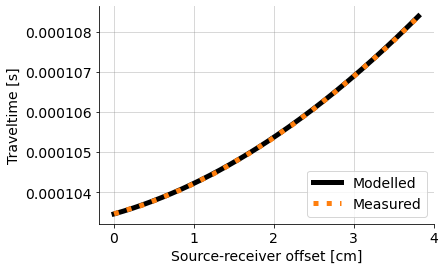

In [21]:
# Model parameters
v_par = 1560
v_perp = 1540
phi = -angle
m = np.array([v_par, v_perp, phi - alpha])


L = sy - 0.005  # probe-reflector vertical distance
d = rx - rx[0]  # source-receiver offset [the source is the first transducer element] 

L2 = L*cos(alpha) + (rx[0]-rx[0])*sin(alpha)  # eq. (11)


# traveltimes [eq. (12)]
ttt_anal = np.sqrt(d*d*(m[0]*m[0]*sin(m[2])**2 + m[1]*m[1]*cos(m[2])**2)/(m[0]*m[0]*m[1]*m[1]) + 
                   (4*L2*L2 + 4*L2*d*sin(alpha))/(m[0]*m[0]*sin(m[2] + alpha)**2 + m[1]*m[1]*cos(m[2] + alpha)**2))


## Plot predicted versus modelled traveltimes

ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)

plt.plot(obs[:,0]*100,ttt_anal, 'k',linewidth=5)
plt.plot(obs[:,0]*100,obs[:,1],':', linewidth=5,c='tab:orange')

plt.grid(color='gray', linestyle='-', linewidth=1, alpha=0.3)

plt.xlabel('Source-receiver offset [cm]')
plt.ylabel('Traveltime [s]')
plt.legend(["Modelled",'Measured'], loc=4)    
plt.rcParams.update({'font.size': 14})